# **Create Ocean Masks for SPEAR Historical**

In [3]:
import netCDF4 as nc
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import linregress
import pandas as pd
from math import nan
import xesmf as xe

In [4]:
dir1 = '/work/Jiale.Lou/shared_data/SPEAR/'
dir2 = '/work/Darri.Stuber'

In [3]:
def get_range(data):
    max_lat = data.lat.max().item()
    min_lat =  data.lat.min().item()

    max_lon =  data.lon.max().item()
    min_lon = data.lon.min().item()

    return (min_lat, max_lat, min_lon, max_lon)

def print_range(data): #help when detecting differences in size between rh/t/sst files
    min_lat, max_lat, min_lon, max_lon = get_range(data)
    print(f'Lat range = ({min_lat}, {max_lat})')
    print(f'Lon range = ({min_lon}, {max_lon})')

def round_coors(data):
    data.coords['lat'] = data.coords['lat'].round(3)
    data.coords['lon'] = data.coords['lon'].round(3)
    return(data)

### Import & Visualize Data + Ranges

In [63]:
#import sst data and rh sample file to check for size matching
rh_sample = xr.open_dataset(dir1 +'/LOW_LE/ens01/atmos.185101-201012.rh_ref.nc')['rh_ref']
    #rh_sample resolution determines mask output. This will create a low res mask
    #rerun for different resolutions
sst = xr.open_dataset(dir1 +f'/HIGH_LE/ens01/ocean.201101-210012.SST.nc')
sst = sst.rename({"xh": "lon", "yh": "lat"})


Lat Range = (-89.5, 89.5)
Lon Range = (0.625, 359.375)


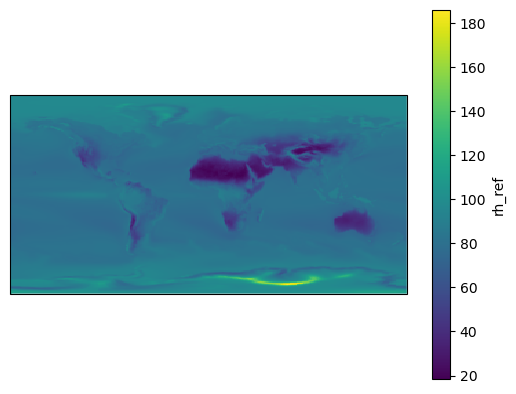

In [65]:
print_range(rh_sample)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 
rh_sample.mean('time').plot()

Lat Range = (-77.77420179896257, 89.89999999999979)
Lon Range = (-299.5, 59.5)


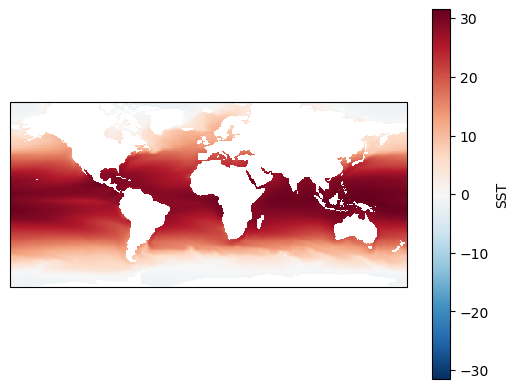

In [66]:
print_range(sst)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 

### Reshape SST file for use as mask

RH range (desired)
Lat Range = (-77.5, 89.5)
Lon Range = (0.625, 359.375)

SST Range (mimic)
Lat Range = (-77.77420179896257, 89.89999999999979)
Lon Range = (0.5, 359.5)


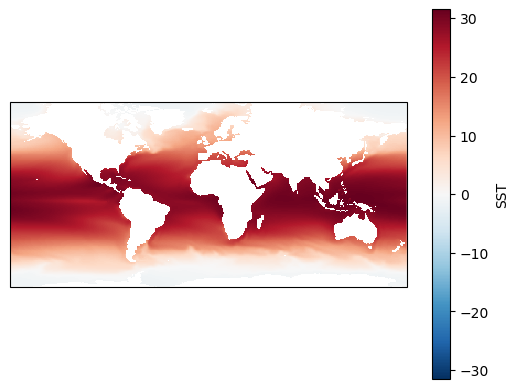

In [67]:
#RESHAPE ocean to be -180, 180 for lat (match rh_sample) 
sst['lon'] = (sst['lon'] + 360) % 360

sst = sst.sortby(["lat", "lon"])

#sst range is smaller, cut rh range to match existing sst range
o_min_lat, o_max_lat, o_min_lon, o_max_lon = get_range(sst) #sst range
rh_slim = rh_sample.sel(lat = slice(o_min_lat, o_max_lat)) #cut rh range to match 
rh_min_lat, rh_max_lat, rh_min_lon, rh_max_lon = get_range(rh_slim) #get new rh range


print('RH range (desired)')
print_range(rh_slim)
print()
print('SST Range (mimic)') #ensure sst range is similar to lat/lon range of rh
print_range(sst)

#visualize to check
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())  
sst.SST.mean('time').plot()


In [68]:
#check increments of rh lat/lon data
rh_lat_inc = rh_slim.lat.isel(lat = 1).item() -rh_slim.lat.isel(lat = 0).item()
print(rh_lat_inc)
rh_lon_inc = rh_slim.lon.isel(lon= 1).item() -rh_slim.lon.isel(lon = 0).item()
print(rh_lon_inc)

1.0
1.25


In [69]:
#ensure lat/lon coors are explicitly assigned 
#rh_slim = rh_slim.assign_coords(lat=('lat', rh_slim['lat'].data), lon=('lon', rh_slim['lon'].data))
#sst = sst.assign_coords(lat=('lat', sst['lat'].data), lon=('lon', sst['lon'].data))

#make a target grid (using lat/lon rh_slim coors) - for later use to reshape sst
target_grid = xr.Dataset({
    'lat': (['lat'], rh_slim['lat'].values),
    'lon': (['lon'], rh_slim['lon'].values)})

#create regrider from target_grid & apply to sst
regridder = xe.Regridder(sst, target_grid, method='bilinear')
sst_regridded = regridder(sst)

sst_regridded

<xarray.Dataset> Size: 209MB
Dimensions:  (time: 1080, lat: 168, lon: 288, nv: 2)
Coordinates:
  * nv       (nv) float64 16B 1.0 2.0
  * time     (time) object 9kB 2011-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat      (lat) float64 1kB -77.5 -76.5 -75.5 -74.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Data variables:
    SST      (time, lat, lon) float32 209MB nan nan nan ... -1.326 -1.322 -1.238
Attributes:
    regrid_method:  bilinear


In [70]:
#check range of sst_regridded & comp to rh_slim
print_range(sst_regridded)
print()
print_range(rh_slim)

Lat Range = (-77.5, 89.5)
Lon Range = (0.625, 359.375)

Lat Range = (-77.5, 89.5)
Lon Range = (0.625, 359.375)


In [ ]:
#old regridding method
'''def regrid(ds_mask, lat_new, lon_new):

    ds_fixed = xr.Dataset({"lat": (["lat"], lat_new), "lon": (["lon"], lon_new)}) #blank new grid with desired lat/lon

    regridder_mask = xe.Regridder(ds_mask, ds_fixed, 'bilinear')
    mask_regridded = regridder_mask(ds_mask)

    return mask_regridded


lat_new = np.arange(rh_min_lat, rh_max_lat+rh_lat_inc, rh_lat_inc)
lon_new = np.arange(rh_min_lon, rh_max_lon+rh_lon_inc, rh_lon_inc)
#lon_new = np.arange(rh_min_lon, rh_max_lon+.05, rh_lon_inc)

sst_regrid = regrid(sst, lat_new, lon_new)
sst_regid = round_coors(sst_regrid)
print('RH range (desired)')
print_range(rh_slim)

print('SST Regridded:')
print_range(sst_regrid)'''

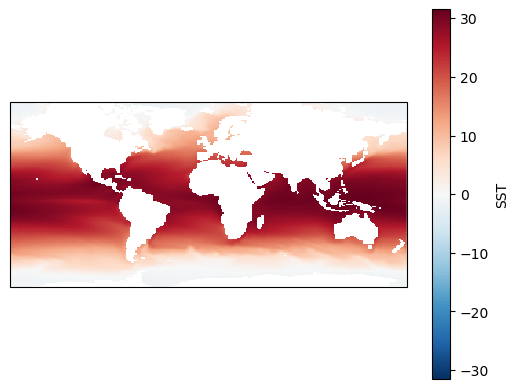

In [71]:
#check sst_regridded
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
sst_regridded.SST.mean('time').plot()

In [73]:
sst_regridded = round_coors(sst_regridded) #ensure no rounding errors
mask = np.isnan(sst_regridded) #differentiate land/ocean locations based on where there is sst (nans are over land) 
intmask = mask.astype(int) #change nas/values to be 0/1s

In [76]:
flatmask = intmask.mean('time') #get rid of the time dimension in new mask
flatmask = flatmask.drop_vars('nv') #get rid of nv var
flatmask = flatmask['SST']
flatmask #should now be exclusively dataarray with lat/lon. SST is coors 0/1 (ocean/land)

<xarray.DataArray 'SST' (lat: 168, lon: 288)> Size: 387kB
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 1kB -77.5 -76.5 -75.5 -74.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4

In [77]:
#double check to make sure everything is rounded (prevent comparison errors) 
rh_slim.coords['lat'] = np.round(rh_slim.coords['lat'].values, 3)
rh_slim.coords['lon'] = np.round(rh_slim.coords['lon'].values, 3)

flatmask.coords['lat'] = np.round(flatmask.coords['lat'].values, 3)
flatmask.coords['lon'] = np.round(flatmask.coords['lon'].values, 3)

#broadcast flat_mask to have the same dimensions as rh_slim (time/lat/lon) 
final_mask = flatmask.broadcast_like(rh_slim)

### Test mask 

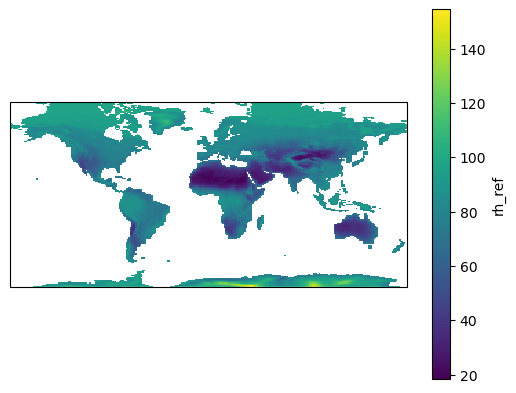

In [78]:
rh_land = rh_slim.where(final_mask == 1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
rh_land.mean('time').plot()

In [ ]:
final_mask.to_netcdf(f'/work/Darri.Stuber/lres_mask.nc') #save working mask

### Secondary test

In [80]:
rh2 = xr.open_dataset(dir1 +'/HIGH_LE/ens02/atmos.192101-201012.rh_ref.nc')['rh_ref']
imported_mask = final_mask

In [101]:
#format rh_slim
omax_lat = sst2.lat.max().item()
omin_lat =  sst2.lat.min().item()

omax_lon =  sst2.lon.max().item()
omin_lon = sst2.lon.min().item()

rh2_slim = rh2.sel(lat = slice(omin_lat, omax_lat), lon = slice(omin_lon, omax_lon))
rh2_slim = round_coors(rh2_slim)

#format mask
imported_mask = imported_mask.sel(lat = slice(-77.625, 89.625))

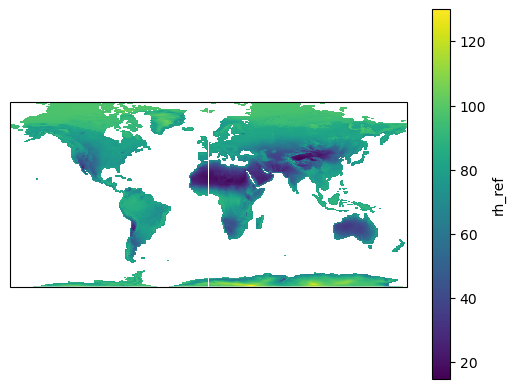

In [105]:
rh_land2 = rh2_slim.where(imported_mask == 1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) #always use projection , zorder = priority (high zorder appears on top_              
rh_land2.mean('time').plot()